# Deep Learning: RNN: Disaster Tweets
**Thomas Bohn**   --   **2025-09-20**

--  [Main Report](https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets/blob/main/deep-learing-rnn-disaster-tweets.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets)  --

# 1.&nbsp;Introduction

**Problem Statement**

Build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

A prediction should be made whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

**Why is it Important?**

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

**Related Kaggle Competion**

[Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview)

**DataSet Description**

Each sample in the train and test set has the following information:
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

**Files Include**
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

**Columns Definitions**
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

**Data Facts**
- **Data Size**: 1.43 MB
- **Training Data Records**: 7,613
- **Training Data Records**: 3,263
- **Classes**: 2 (Binary)

## Python Libraries

The following python libraries are used in this notebook.

In [88]:
# File system manangement
import time, datetime, psutil, os
import shutil
import zipfile
from google.colab import userdata
from google.colab import files

# Data manipulation
import numpy as np
import pandas as pd
import math

# Install text storage and manipulation
import re
import json
import pickle
import textwrap

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

###################################

# NLP
import string, re, nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

###################################

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

#################################

# Import Tensor Flow and Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.models import Sequential
from keras.initializers import Constant
from tensorflow.keras.layers import (
    LSTM,
    Embedding,
    BatchNormalization,
    Dense,
    TimeDistributed,
    Dropout,
    Bidirectional,
    Flatten,
    GlobalMaxPool1D
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    History,
    ModelCheckpoint
)
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.regularizers import l2

#################################

# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

print('#### ALL DONE! ####')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
#### ALL DONE! ####


## Global Variables

The following are global variables referenced in this notebook.

In [15]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [16]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = True
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Debug is set to: True
Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

In this section, the code loads the dataset from Google Drive. A copy of the code from Kaggle was cached on google drive for development in a colab environment.

## Import GloVe

In [81]:
# Define the source of the zipped data files
target_file = 'glove.6B.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

# Copy the files to the runtime
shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

# Display the files in the destination directory
print(os.listdir(destination_path_root+'/'))

['.config', 'glove.6B.zip', 'nlp-getting-started.zip', 'test.csv', 'sample_submission.csv', 'drive', 'train.csv', 'sample_data']


In [82]:
# Unzip the files (this is slow)
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [83]:
# Define the file paths in the runtime environment
file_path_root =  '/content'

file_path_glove   = file_path_root + '/glove.6B.100d.txt'

print("GloVe File Path:", file_path_glove)

GloVe File Path: /content/glove.6B.100d.txt


## Import the Data

In [17]:
# Define the source of the zipped data files
target_file = 'nlp-getting-started.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

# Copy the files to the runtime
shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

# Display the files in the destination directory
print(os.listdir(destination_path_root+'/'))

['.config', 'nlp-getting-started.zip', 'test.csv', 'sample_submission.csv', 'drive', 'train.csv', 'sample_data']


In [18]:
# Unzip the files (this is slow)
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [19]:
# Define the file paths in the runtime environment
file_path_root =  '/content'

file_path_train   = file_path_root + '/train.csv'
file_path_test    = file_path_root + '/test.csv'
file_path_sample  = file_path_root + '/sample_submission.csv'

# Load train labels from CSV file
train_labels = pd.read_csv(file_path_train)

# Load test labels from CSV file
test_labels = pd.read_csv(file_path_test)

# Load test labels from CSV file
sample_output = pd.read_csv(file_path_sample)

## Create Label Mappings

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [20]:
 # Encoding of labels
label_dict = {'not': 0, 'disaster': 1}
# Create the inverse dictionary
inverted_label_dict = {0: 'not', 1: 'disaster'}
print('label_dict:', label_dict)
print('inverted_label_dict:', inverted_label_dict)

label_dict: {'not': 0, 'disaster': 1}
inverted_label_dict: {0: 'not', 1: 'disaster'}


## Add Basic Columns

In [21]:
# Add Additional Columns to training data
train_labels['label']=train_labels['target']
train_labels['length']=train_labels['text'].str.len()
train_labels['word_count']=train_labels['text'].str.split().str.len()

# Add Additional Columns to testing data
test_labels['length']=test_labels['text'].str.len()
test_labels['word_count']=test_labels['text'].str.split().str.len()

## Preview Data

In [22]:
if gDEBUG:
  # Preview the Data Sources
  print("Sample of Training Labels")
  display(train_labels.head(5))
  print()
  print("Sample of Testing Data")
  display(test_labels.head(5))
  print()
  print("Sample of Results Output:")
  display(sample_output.head(5))

Sample of Training Labels


,id,keyword,location,text,target,label,length,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,88,16



Sample of Testing Data


,id,keyword,location,text,length,word_count
0,0,NaN,NaN,Just happened a terrible car crash,34,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45,8



Sample of Results Output:


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [23]:
# Display training labels info
print("Training Labels Info:")
print(train_labels.info())
print()
# Display testing labels info
print("Testing Data Info:")
print(test_labels.info())
print()

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   label       7613 non-null   int64 
 6   length      7613 non-null   int64 
 7   word_count  7613 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 475.9+ KB
None

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3263 non-null   int64 
 1   keyword     3237 non-null   object
 2   location    2158 non-null   object
 3   text        3263 non-null   object
 4   length      3263 non-null   int64 
 5   word

In [24]:
 # Preview the Training Label Assignments
print('Label Count of Training Labels')
display(train_labels['target'].value_counts())
print()
print('Imbalance of Labels:', round((train_labels['target'].value_counts()[1]
                                    - train_labels['target'].value_counts()[0]) / len(train_labels), 3))


Label Count of Training Labels


,count
target,
0,4342
1,3271



Imbalance of Labels: -0.141


In [25]:
# Example of the text from the article
example_text = train_labels['text'].iloc[100]
# Print to Screen
print("Length of Text:", len(example_text), "\n")
print(textwrap.fill(example_text, width=100))

Length of Text: 124 

.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion
https://t.co/gFJfgTodad


# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Various functions are used to inspect the structure of the dataset, visualize the label distribution, and assess the text length and word count of the documentation. The data is found to be somewhat imbalanced across categories.

## EDA Functions

EDA Functions recycled from previous Natural Language Processing (NLP) analysis projects. The general patter of completing EDA for NLP typically starts with a standard set of tables and charts to understand the data.*italicized text*

*Source:* [auto_classifying_salesforce_cloud_documentation.ipynb](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/0f26d4b049e22b43e3bffd348e7687b4640c30d2/auto_classifying_salesforce_cloud_documentation.ipynb)

In [26]:
# Function to replace labels in a list based on a label dictionary
def replace_labels(labels, label_dict):
  new_labels = []
  # Iterate through each label in the input list
  for label in labels:
    # If the label exists in the label dictionary, append the replacement label
    if label in label_dict:
      new_labels.append(label_dict[label])
    else:
      new_labels.append(label)

  return new_labels

In [27]:
# Create a dictionary to store the data for each label
def create_data_by_label(data, label_col):
  data_by_label = {}
  # Iterate over the unique labels
  for label in data['label'].unique():
      # Subset the data for the current label
      data_by_label[label] = data[data['label'] == label]

  print("Size of the data by label dictionary:", len(data_by_label), "\n")

  return data_by_label

In [28]:
# Create a function to print key table details
def quick_table_details (df_name, df, level_of_detail = 10):
  # describe the shape and column summary
  if level_of_detail >= 1:
    print('\n####', df_name, '####')
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    print('number of features (columns) = ' + str(num_cols))
    print('number of observations (rows) = ' + str(num_rows))
    print('----------------------------', '\n')
  # print the datatype counts
  if level_of_detail >= 2:
    print('DataType Counts:')
    display(df.dtypes.value_counts())
    print('----------------------------', '\n')
  # print a full list of column names
  if level_of_detail >= 3:
    print('Columns:')
    print(df.columns)
    print('----------------------------', '\n')
  #  expanded table details
  if level_of_detail >= 4:
    print('Description:')
    display(df.describe(include='all'))
    print('----------------------------', '\n')
    print('Info:')
    display(df.info())
    print('----------------------------', '\n')
  #  table records preview
  if level_of_detail >= 5:
    print('Table Preview:')
    x_records = 3
    display(df.head(x_records))
    print('....')
    display(df.tail(x_records))
    print('----------------------------', '\n')

In [29]:
# function to count the number of records in each category and stats
def count_field(df, field = 'label'):
    df_cat_count = pd.DataFrame(df[field].value_counts()).reset_index()
    #df_cat_count = df_cat_count.rename(columns={'label': 'Count', 'index': 'Label'})
    df_cat_count = df_cat_count.sort_values(by = ['count'], ascending = False)
    df_cat_count['Pct of Total'] = round(df_cat_count['count'] / df_cat_count['count'].sum(), 2)
    df_cat_count['Pct of Total Text'] = (df_cat_count['Pct of Total'] * 100).apply(int).apply(str) + ' %'
    return df_cat_count

In [30]:
# define a function to aggregate dataframe on a single category
def shape_df_for_stacked_barchart(df, group_by, stack_by, normalize=True):
    # Check if group_by and stack_by are the same
    if group_by == stack_by:
        # If they are the same, simply return the value counts as a DataFrame
        df_chart = df[group_by].value_counts(normalize=normalize).round(2).to_frame()
        df_chart.index.name = stack_by  # Set the index name for consistency
    else:
        # If they are different, proceed with the original logic
        df_chart = (df
                    .groupby(group_by)[stack_by]
                    .value_counts(normalize=normalize)
                    .round(2)
                    .unstack())
    return df_chart

# defgine a function to plot a bar chart for a single category
def create_single_stacked_bar(df, group_by, stack_by, fig_size = (5,5), normalize=True):
  df_chart = shape_df_for_stacked_barchart(df = df, group_by = group_by, stack_by = stack_by, normalize = normalize)
  if gDEBUG: print(df_chart, '\n')
  fig, ax = plt.subplots(figsize = fig_size)
  # plot the chart
  chart = df_chart.plot.bar(stacked = True,
                    ax = ax,
                    width = 0.3,
                    edgecolor = "black")
  # Customising legend
  ax.legend(fontsize = 10, title_fontsize = 10)

  ax.set_title(group_by, fontsize=10)
  ax.set_xlabel(group_by, fontsize=8)
  ax.set_ylabel('Record Count', fontsize=8)
  return fig


In [31]:
# Visualization of class frequencies
def viz_class_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(len(data_by_label[i]))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  print(values)
  print(labels)

  # Create the horizontal bar chart
  plt.barh(labels, values)

  # Add labels and title
  plt.xlabel("Record Count")
  plt.ylabel("Labels")
  plt.title("Comparison of Class Frequencies")

  # Display the chart
  plt.show()

In [32]:
# Distribution of number of characters in description
def viz_char_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.len())
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of number of characters in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Number of characters") # Change: Use cols instead of 2
      if i % cols != 0: axs[i].set_ylabel(" ") # Change: Use cols instead of 2

In [33]:
# Distribution of number of words in description
def viz_word_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.split().map(lambda x: len(x)))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of number of words in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Number of words") # Change: Use cols instead of 2
      if i % cols != 0: axs[i].set_ylabel(" ") # Change: Use cols instead of 2

In [34]:
# Distribution of number of words in description
def viz_word_length_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of average word-length in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Average word-length")
      if i % cols != 0: axs[i].set_ylabel(" ")

## EDA Analysis: Overview

In [35]:
# Print summary details for the 3 tables in the datasource
quick_table_details (df_name="train_labels", df=train_labels, level_of_detail = 4)


#### train_labels ####
number of features (columns) = 8
number of observations (rows) = 7613
---------------------------- 

DataType Counts:


,count
int64,5
object,3


---------------------------- 

Columns:
Index(['id', 'keyword', 'location', 'text', 'target', 'label', 'length',
       'word_count'],
      dtype='object')
---------------------------- 

Description:


,id,keyword,location,text,target,label,length,word_count
count,7613.000000,7552,5080,7613,7613.00000,7613.00000,7613.000000,7613.000000
unique,NaN,221,3341,7503,NaN,NaN,NaN,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN,NaN,NaN,NaN
freq,NaN,45,104,10,NaN,NaN,NaN,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966,0.42966,101.037436,14.903586
std,3137.116090,NaN,NaN,NaN,0.49506,0.49506,33.781325,5.732604
min,1.000000,NaN,NaN,NaN,0.00000,0.00000,7.000000,1.000000
25%,2734.000000,NaN,NaN,NaN,0.00000,0.00000,78.000000,11.000000
50%,5408.000000,NaN,NaN,NaN,0.00000,0.00000,107.000000,15.000000
75%,8146.000000,NaN,NaN,NaN,1.00000,1.00000,133.000000,19.000000


---------------------------- 

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   label       7613 non-null   int64 
 6   length      7613 non-null   int64 
 7   word_count  7613 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 475.9+ KB


None

---------------------------- 



In [36]:
# show the content of one Article in the data source
print(textwrap.fill(train_labels['text'][55], width=100))

#Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen
Front in #Diyala http://t.co/4IzFdYC3cg


In [37]:
#print column names for each table
print('columns in df_train:', train_labels.columns)
# calculate the count of records in each category
df_cat_count = count_field(df = train_labels, field = 'target')
display(df_cat_count)

columns in df_train: Index(['id', 'keyword', 'location', 'text', 'target', 'label', 'length',
       'word_count'],
      dtype='object')


,target,count,Pct of Total,Pct of Total Text
0,0,4342,0.57,56 %
1,1,3271,0.43,43 %


        count
target       
0        4342
1        3271 

[-] the catgory of 0 makes up 56 % of the data.
[-] the catgory of 1 makes up 43 % of the data.


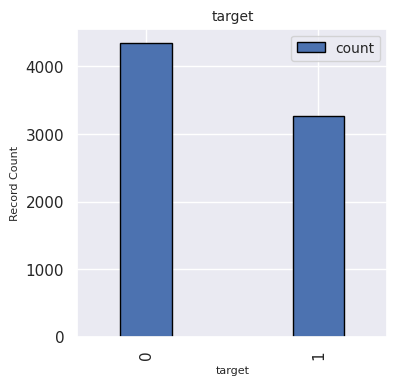

In [38]:
# Summarize the target in the dataset
chart = create_single_stacked_bar(df = train_labels, group_by = 'target', stack_by = 'target', fig_size = (4,4), normalize = False)
table = shape_df_for_stacked_barchart(df = train_labels, group_by = 'target', stack_by = 'target', normalize = False)
# Print a summary of the percent share of the total for each category
for i in range(len(df_cat_count)):
    print('[-] the catgory of', df_cat_count['target'].iloc[i], 'makes up',
           df_cat_count['Pct of Total Text'].iloc[i], 'of the data.')

## EDA Analysis: Text Distribution

Size of the data by label dictionary: 2 

[4342, 3271]
['not', 'disaster']


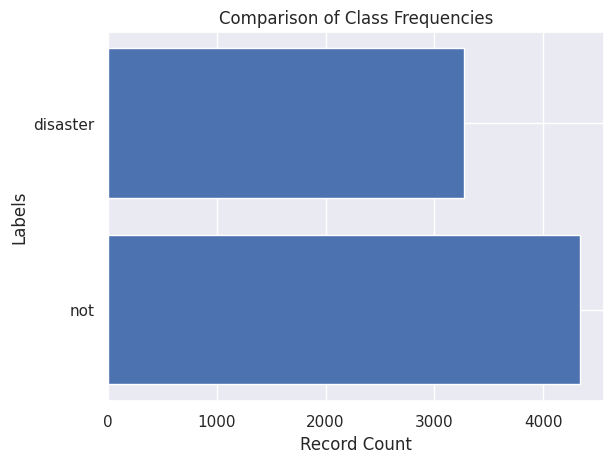

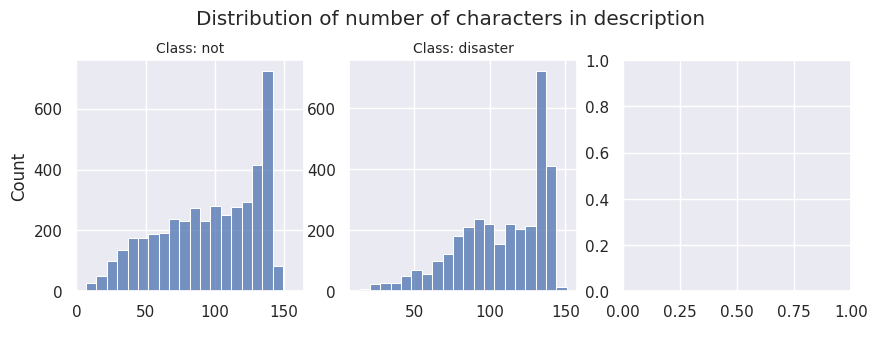

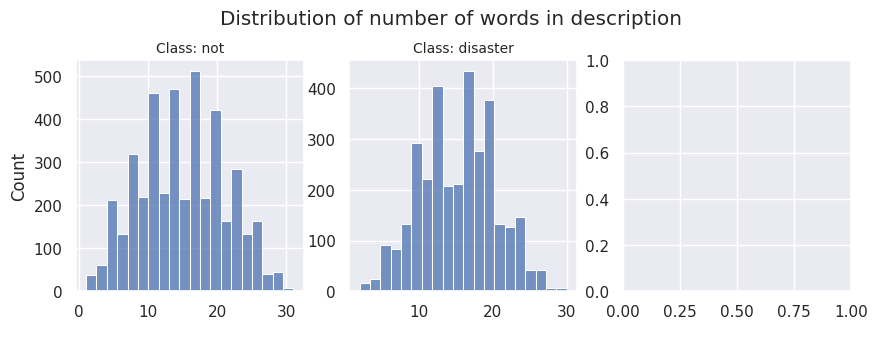

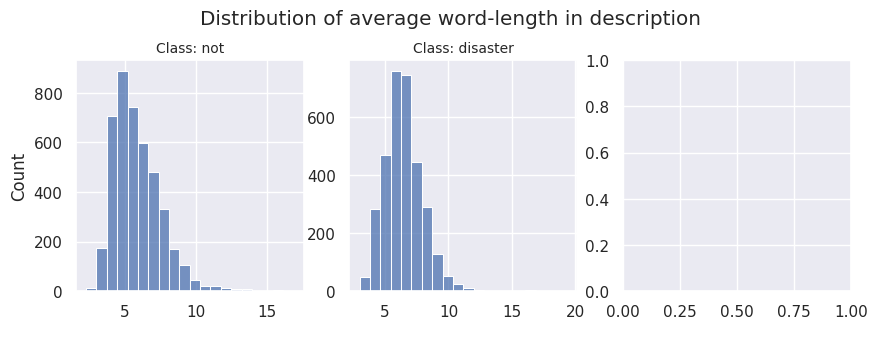

In [39]:
data_by_label = create_data_by_label(data=train_labels, label_col='label')
# Distribution of number of characters in description
viz_class_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of characters in description
viz_char_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_length_frequency(data_by_label, label_dict = inverted_label_dict)

## EDA Results

ADD HERE

# 4.&nbsp;Data Cleansing & Text Normalization

Address missing values and duplicates, followed by a series of text preprocessing steps. Text pre-processing includes converting text to lowercase, removing punctuation, handling HTML tags, and applying stemming/lemmatization. These cleaning functions ensure the data is standardized and ready for further analysis.

## Core Normalization Functions

EDA Functions recycled from previous Natural Language Processing (NLP) analysis projects. The general patter of completing EDA for NLP typically starts with a standard set of tables and charts to understand the data.*italicized text*

*Source:* [auto_classifying_salesforce_cloud_documentation.ipynb](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/0f26d4b049e22b43e3bffd348e7687b4640c30d2/auto_classifying_salesforce_cloud_documentation.ipynb)

In [50]:
#Track a list of the descriptions and the function names
tn_funct = []; tn_desc = []

# RegexpTokenizer
regexp =RegexpTokenizer(r"[\w']+")

# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

if gDEBUG:
  tn_funct.append('convert_to_lowercase(text)')
  tn_desc.append('Converting to lowercase')
  print('Testing', tn_funct[-1], "...")
  text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
  print("Input: {}".format(text))
  print("Output: {}".format(convert_to_lowercase(text)))
  print()

# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

if gDEBUG:
  tn_funct.append('remove_whitespace(text)')
  tn_desc.append('Removing whitespaces')
  print('Testing', tn_funct[-1], "...")
  text = " \t This is a string \t "
  print("Input: {}".format(text))
  print("Output: {}".format(remove_whitespace(text)))
  print()

# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

if gDEBUG:
  tn_funct.append('remove_punctuation(text)')
  tn_desc.append('Removing punctuations')
  print('Testing', tn_funct[-1], "...")
  text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
  print("Input: {}".format(text))
  print("Output: {}".format(remove_punctuation(text)))
  print()

# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

if gDEBUG:
  tn_funct.append('remove_html(text)')
  tn_desc.append('Removing HTML tags')
  print('Testing', tn_funct[-1], "...")
  text = ' Ecommerce Text Classification '
  print("Input: {}".format(text))
  print("Output: {}".format(remove_html(text)))
  print()

# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

if gDEBUG:
  tn_funct.append('remove_emoji(text)')
  tn_desc.append('Removing emojis')
  print('Testing', tn_funct[-1], "...")
  text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
  print("Input: {}".format(text))
  print("Output: {}".format(remove_emoji(text)))
  print()

# Removing other unicode characters
def remove_http(text):
    http = r"https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

if gDEBUG:
  tn_funct.append('remove_http(text)')
  tn_desc.append('Removing other unicode characters')
  print('Testing', tn_funct[-1], "...")
  text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
  print("Input: {}".format(text))
  print("Output: {}".format(remove_http(text)))
  print()

# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

if gDEBUG:
  print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))
  print()

# List of acronyms
acronyms_list = list(acronyms_dict.keys())

# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

if gDEBUG:
  tn_funct.append('convert_acronyms(text)')
  tn_desc.append('convert contractions in a text')
  print('Testing', tn_funct[-1], "...")
  text = "btw you've to fill in the details including dob"
  print("Input: {}".format(text))
  print("Output: {}".format(convert_acronyms(text)))
  print()

# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

if gDEBUG:
  print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))
  print()

# List of contractions
contractions_list = list(contractions_dict.keys())

# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

if gDEBUG:
  tn_funct.append('convert_contractions(text)')
  tn_desc.append('convert contractions in a text')
  print('Testing', tn_funct[-1], "...")
  text = "he's doin' fine"
  print("Input: {}".format(text))
  print("Output: {}".format(convert_contractions(text)))
  print()

# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

if gDEBUG:
  tn_funct.append('remove_stopwords(text)')
  tn_desc.append('remove stopwords from a list of texts')
  print('Testing', tn_funct[-1], "...")
  text = "This is a function that removes stopwords in a given text"
  print("Input: {}".format(text))
  print("Output: {}".format(remove_stopwords(text)))
  print()

# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

if gDEBUG:
  tn_funct.append('pyspellchecker(text)')
  tn_desc.append('remove to fix spelling errors in texts')
  print('Testing', tn_funct[-1], "...")
  text = "I'm goinng therre"
  print("Input: {}".format(text))
  print("Output: {}".format(pyspellchecker(text)))
  print()

# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

if gDEBUG:
  tn_funct.append('text_stemmer(text)')
  tn_desc.append('Stemming')
  print('Testing', tn_funct[-1], "...")
  text = "Introducing lemmatization as an improvement over stemming"
  print("Input: {}".format(text))
  print("Output: {}".format(text_stemmer(text)))
  print()

# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

if gDEBUG:
  tn_funct.append('text_lemmatizer(text)')
  tn_desc.append('Lemmatization')
  print('Testing', tn_funct[-1], "...")
  text = "Introducing lemmatization as an improvement over stemming"
  print("Input: {}".format(text))
  print("Output: {}".format(text_lemmatizer(text)))
  print()

# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

if gDEBUG:
  tn_funct.append('discard_non_alpha(text)')
  tn_desc.append('Discardment of non-alphabetic words')
  print('Testing', tn_funct[-1], "...")
  text = "It is an ocean of thousands and 1000s of crowd"
  print("Input: {}".format(text))
  print("Output: {}".format(discard_non_alpha(text)))
  print()

def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

if gDEBUG:
  tn_funct.append('keep_pos(text)')
  tn_desc.append('Keep specific parts of speach')
  print('Testing', tn_funct[-1], "...")
  text = "He arrived at seven o'clock on Wednesday evening"
  print("Input: {}".format(text))
  tokens = regexp.tokenize(text)
  print("Tokens: {}".format(tokens))
  tokens_tagged = nltk.pos_tag(tokens)
  print("Tagged Tokens: {}".format(tokens_tagged))
  print("Output: {}".format(keep_pos(text)))
  print()

# Additional stopwords
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

if gDEBUG:
  tn_funct.append('remove_additional_stopwords')
  tn_desc.append('Custom list of stop words to remove')
  print('Testing', tn_funct[-1], "...")
  print('no test defined.')

Testing convert_to_lowercase(text) ...
Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase

Testing remove_whitespace(text) ...
Input:  	 This is a string 	 
Output: This is a string

Testing remove_punctuation(text) ...
Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations

Testing remove_html(text) ...
Input:  Ecommerce Text Classification 
Output:  Ecommerce Text Classification 

Testing remove_emoji(text) ...
Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 

Testing remove_http(text) ...
Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 

Example: Ori

In [51]:
# Execute the set of desired text normalization functions
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub(r'\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    # text = pyspellchecker(text)
    text = text_lemmatizer(text)
    # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))
print()

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description



In [77]:
# Apply the text normalization to the data sets and summerize the application
def apply_text_normalizer(data_train, data_test):
  # Implementing text normalization
  data_train_norm, data_test_norm = pd.DataFrame(), pd.DataFrame()

  data_train_norm['normalized_text'] = data_train['text'].apply(text_normalizer)
  data_test_norm['normalized_text'] = data_test['text'].apply(text_normalizer)

  data_train_norm['label'] = data_train['label']
  data_test_norm['label'] = data_test['label']

  data_train['normalized_text'] = data_train_norm['normalized_text']
  data_test['normalized_text'] = data_test_norm['normalized_text']

  print("Size of the training set:", len(data_train_norm))
  print("Size of the test set:", len(data_test_norm))
  print()
  print("Labels in training set:", data_train_norm['label'].nunique())
  print("Labels in test set:", data_test_norm['label'].nunique())
  print()
  # Display Training Output (normalized)
  print("Sample of test set [normalized]:\n")
  print("Columns in test set [normalized]:", data_test_norm.columns, "\n")
  display(data_train_norm.head(3))
  print()
  # Display Training Input
  print("Sample of test set [data]:\n")
  print("Columns in test set [data]:", data_test.columns, "\n")
  display(data_train.head(3))
  print()

  return data_train_norm, data_test_norm, data_train, data_test

## Apply Text Normalization

In [78]:
%%time
# Apply text normalization
data_train_norm, data_test_norm, data_train, data_test  = apply_text_normalizer(train_df, test_df)

Size of the training set: 5233
Size of the test set: 3263

Labels in training set: 2
Labels in test set: 1

Sample of test set [normalized]:

Columns in test set [normalized]: Index(['normalized_text', 'label'], dtype='object') 



,normalized_text,label
2608,see line blow,0
2114,pandemonium aba woman deliver baby face photo,0
4596,add responder lose home vip home page group vimeo,1



Sample of test set [data]:

Columns in test set [data]: Index(['id', 'keyword', 'location', 'text', 'length', 'word_count', 'label',
       'normalized text', 'normalized_text'],
      dtype='object') 



,id,keyword,location,text,target,label,length,word_count,normalized text,normalized_text
2608,1082,blew%20up,"Greensboro, NC",@b24fowler I see that! Crazy how this line ble...,0,0,51,10,see line blow,see line blow
2114,7622,pandemonium,www.facebook.com/stuntfm,Pandemonium In Aba As Woman Delivers Baby With...,0,0,88,12,pandemonium aba woman deliver baby face photo,pandemonium aba woman deliver baby face photo
4596,5428,first%20responders,New York City,I just added 'Sandy First Responders Lost Thei...,1,1,112,17,add responder lose home vip home page group vimeo,add responder lose home vip home page group vimeo



CPU times: user 42.2 s, sys: 25.4 ms, total: 42.2 s
Wall time: 49.2 s


In [79]:
if gDEBUG:
  # Preview the changes for the before and after text
  print(textwrap.fill(data_train['text'][0], width=100))
  print('\n## change to ##\n')
  print(textwrap.fill(data_train['normalized_text'][0], width=100))

My woman crush wedneday goes to the beautiful @taykreidler #loveyouuuu #aintsheperty
https://t.co/WeMwdtFwiC

## change to ##

woman crush wedneday go taykreidler loveyouuuu aintsheperty


# 5.&nbsp;Work Embeddings + Vectorization

XXXXX

## Word Embeddings from GloVe

In [152]:
train_texts = data_train_norm['normalized_text'].values
train_target = data_train_norm['label'].values.astype('int')
test_texts = data_test['normalized_text'].values
test_ids = data_test['id'].values

In [121]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

9150

In [122]:
# Pad_sequences
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(train_texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_texts),
    length_long_sentence,
    padding='post'
)

test_padded_sentences = pad_sequences(
    embed(test_texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[   9,  266,  138, ...,    0,    0,    0],
       [ 284,  631,   69, ...,    0,    0,    0],
       [ 467,  238,  487, ...,    0,    0,    0],
       ...,
       [3154,  323,  514, ...,    0,    0,    0],
       [1966, 2242,  435, ...,    0,    0,    0],
       [9148,  479,  902, ...,    0,    0,    0]], dtype=int32)

In [124]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open(file_path_glove) as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [125]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14432999,  0.43950999,  0.58323997, ...,  0.50133997,
         0.49535999,  0.49919999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# 4.&nbsp;Train-Validation-Test Split

Split the dataset into training, validation, and test sets. Use tratified splitting to ensure that the class distribution remains consistent across these sets. The distribution of records across the labels is visualized to ensure a balanced split.

## Test Data Split Functions

Test Split Functions recycled from previous Natural Language Processing (NLP) analysis projects. The general patter of completing EDA for NLP typically starts with a standard set of tables and charts to understand the data.*italicized text*

*Source:* [deep_learning_cnn_cancer_detection.ipynb](https://github.com/TOM-BOHN/MsDS-deep-learing-cnn-cancer-detection/blob/26da0f73632649319b7ff4674b49b42e8ba7a2a2/deep_learning_cnn_cancer_detection.ipynb)

## Test Data Split Execution

In [126]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(
    train_padded_sentences,
    train_target,
    test_size=0.2,
    stratify=train_target,
    random_state=27
)

In [127]:
# Preview Output
if gDEBUG:
  print(X_train[:2])
  print(y_train[:4])
  print(X_val[:2])
  print(y_val[:4])

[[533  49  49 349  64 902   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [182 264 248  60  83  94  14  76 352  99   0   0   0   0   0   0   0   0
    0]]
[0 1 1 0]
[[ 361   27  290   68  129 3318  140  699    0    0    0    0    0    0
     0    0    0    0    0]
 [  80  290   54  137 3220 1909  184    0    0    0    0    0    0    0
     0    0    0    0    0]]
[0 0 1 1]


# 7.&nbsp; Baseline Models: LSTM (RNN)

## Model Functions

In [128]:
# Display a learning curve and a loss curve
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

In [129]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [130]:
# Define a time element to add to history of model training
class EpochTimeHistory(Callback):
    """A custom Keras callback to record the duration of each epoch."""
    def on_epoch_begin(self, epoch, logs=None):
        # Record the start time at the beginning of each epoch
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Calculate the epoch's duration
        epoch_duration = time.time() - self.epoch_start_time

        # Add the duration to the logs dictionary.
        # Keras will automatically include this in the final history object.
        if logs is not None:
            logs['epoch_duration'] = epoch_duration

In [131]:
#ensure the output directory for saved models exists
save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
os.makedirs(save_dir, exist_ok=True) # This creates the folder if it doesn't exist

## Build the Model Architecture

In [160]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

def glove_lstm():
    # Build the model
    model = Sequential()
    # Cofigure the architecture
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix]
    ))
    # Cofigure the architecture
    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))
    # Cofigure the architecture
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile the model
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [161]:
# Create an instance of the model
model_0 = glove_lstm()
# Manually build the model
model_0.build(input_shape=(None, length_long_sentence))
# Display the model summary
model_0.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 19, 100)        │       915,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 19, 38)         │        18,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 38)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38)             │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 19)             │           741 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 934,533 (3.56 MB)

 Trainable params: 934,457 (3.56 MB)

 Non-trainable params: 76 (304.00 B)

## Train/Fit the Model

In [162]:
# Callbacks for early stopping and reducing learning rate
time_history_callback_0 = EpochTimeHistory()
early_stopping_0 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_0 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

In [163]:
history_0 = model_0.fit(
    X_train,
    y_train,
    epochs = 20,
    batch_size = 64,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [early_stopping_0, reduce_lr_0, time_history_callback_0]
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.5254 - loss: 0.8568 - val_accuracy: 0.6151 - val_loss: 0.6808 - learning_rate: 0.0010 - epoch_duration: 12.5777
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5796 - loss: 0.7162 - val_accuracy: 0.6714 - val_loss: 0.6716 - learning_rate: 0.0010 - epoch_duration: 4.9596
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5961 - loss: 0.6747 - val_accuracy: 0.7326 - val_loss: 0.6538 - learning_rate: 0.0010 - epoch_duration: 5.1778
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.6355 - loss: 0.6466 - val_accuracy: 0.7650 - val_loss: 0.6158 - learning_rate: 0.0010 - epoch_duration: 5.6811
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6880 - loss: 0.5844 - val_accuracy: 0.7689 - val_loss: 0.5769 - learning_rate: 0.0010 - epoch_duration: 3.2641
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.7193 - loss: 0.5503 - val_accuracy: 0.7765 - val_loss

In [164]:
# Save the model and the history
model_0_path = os.path.join(save_dir, 'rnn_model_0.keras')
history_0_path = os.path.join(save_dir, 'rnn_history_0.pkl')
model_0.save(model_0_path)
with open(history_0_path, 'wb') as f:
    pickle.dump(history_0.history, f)

print(f"History saved to {save_dir}")

History saved to /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models


## Evaluate the Model

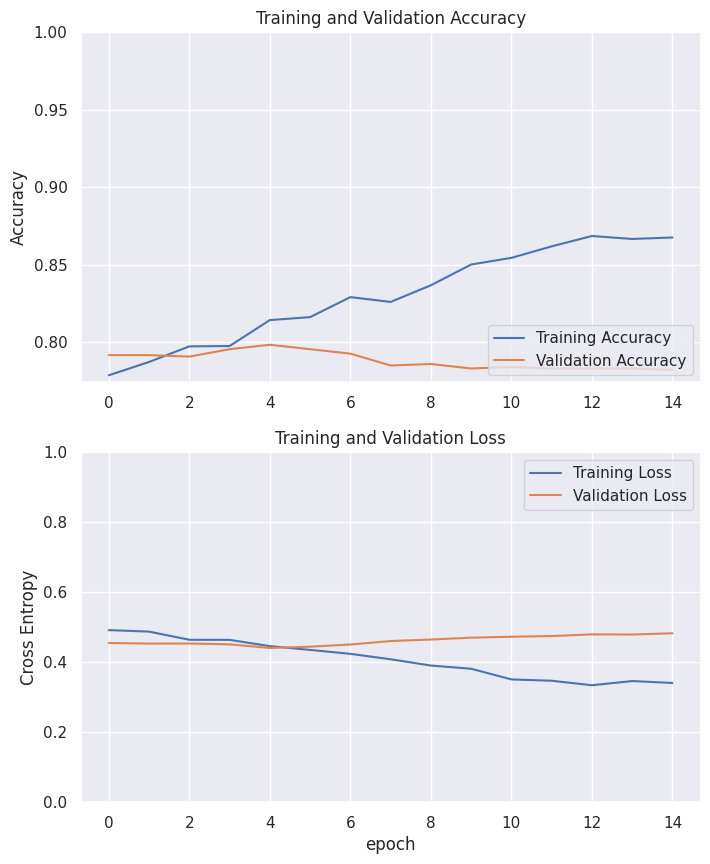

In [139]:
# Display the learning curve and loss curve
learning_curve(history_0)

In [141]:
loss, accuracy = model_0.evaluate(X_val, y_val)
print('Loss:', loss)
print('Accuracy:', accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7927 - loss: 0.4344
Loss: 0.4408441185951233
Accuracy: 0.7984718084335327


In [147]:
pred_val = model_0.predict(X_val)
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
show_metrics(label_pred_val, y_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score:  0.7835897435897435
Precision:  0.7304015296367112
Recall:  0.8451327433628318
Acuracy:  0.7984718242597899
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       595
           1       0.73      0.85      0.78       452

    accuracy                           0.80      1047
   macro avg       0.80      0.80      0.80      1047
weighted avg       0.81      0.80      0.80      1047



# 8.&nbsp; Hyperparameter Tuning

## Tuning Functions

In [ ]:
{{xxxxx}}

## Execute Hyperparameter Tuning

In [ ]:
{{xxxxx}}

# 9.&nbsp;Final Prediction and Evaluation

## Import the Best and Final Model

In [165]:
# Load the best model from the saved models
save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
model_best_path = os.path.join(save_dir, 'rnn_model_0.keras')
history_best_path = os.path.join(save_dir, 'rnn_history_0.pkl')

loaded_model_best = models.load_model(model_best_path)

with open(history_best_path, 'rb') as f:
    loaded_history_dict_best = pickle.load(f)

loaded_history_best = History()
loaded_history_best.history = loaded_history_dict_best
loaded_history_best.epoch = list(range(len(loaded_history_dict_best['loss'])))

## Review and Evaluate the Model

In [166]:
# Review Model Architecture
loaded_model_best.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 19, 100)        │       915,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 19, 38)         │        18,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 38)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38)             │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 19)             │           741 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,868,992 (7.13 MB)

 Trainable params: 934,457 (3.56 MB)

 Non-trainable params: 76 (304.00 B)

 Optimizer params: 934,459 (3.56 MB)

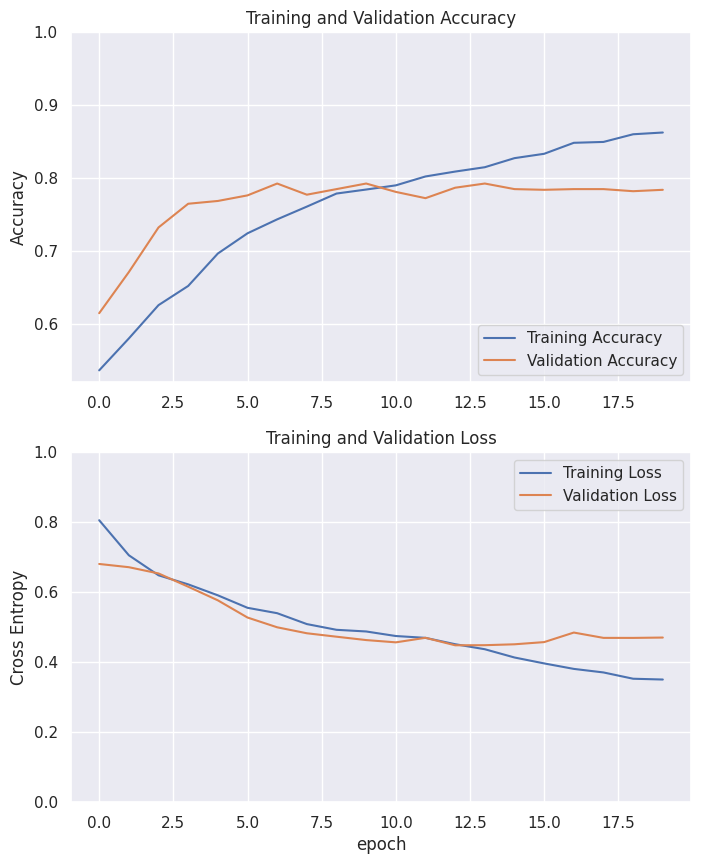

In [167]:
# Review the Accuracy and Validation Loss Charts
learning_curve(loaded_history_best)

In [168]:
# Review the epoch results
loaded_history_best
history_best_df = pd.DataFrame(loaded_history_best.history)
history_best_df.index += 1
print("\n--- Full Training History with Epoch Times ---")
print(history_best_df)


--- Full Training History with Epoch Times ---
    accuracy      loss  val_accuracy  val_loss  learning_rate  epoch_duration
1   0.536789  0.805829      0.615091  0.680810         0.0010       12.577734
2   0.580506  0.705661      0.671442  0.671589         0.0010        4.959616
3   0.626135  0.648444      0.732569  0.653765         0.0010        5.177787
4   0.652413  0.622533      0.765043  0.615841         0.0010        5.681147
5   0.696847  0.591179      0.768863  0.576899         0.0010        3.264083
6   0.724558  0.555555      0.776504  0.527757         0.0010        6.899826
7   0.743669  0.540156      0.792741  0.499879         0.0010        2.959999
8   0.761108  0.509063      0.777459  0.482817         0.0010        5.765664
9   0.779025  0.492701      0.785100  0.472998         0.0010        5.286717
10  0.784520  0.487943      0.792741  0.463360         0.0010        2.814132
11  0.790253  0.474937      0.781280  0.456876         0.0010        2.977183
12  0.802437  0.

In [169]:
pred_val = loaded_model_best.predict(X_val)
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
show_metrics(label_pred_val, y_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
F1-score:  0.7679500520291364
Precision:  0.7055449330783938
Recall:  0.8424657534246576
Acuracy:  0.7870105062082139
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       609
           1       0.71      0.84      0.77       438

    accuracy                           0.79      1047
   macro avg       0.79      0.79      0.79      1047
weighted avg       0.80      0.79      0.79      1047



# 11.&nbsp; Conclusions

{{xxxxx}}

## Results Summary

### Model Result Summary


**Baseline Results**

{{xxxxx}}

**Hyperparameter Tuning Results**

{{xxxxx}}

**Best Model Results**

{{xxxxx}}

**Best Model Performance**

{{xxxxx}}

## Model Comparison

### Model Comparisons and Findings

{{xxxxx}}

#### Baseline Results

{{xxxxx}}

#### Hyperparameter Tuning

{{xxxxx}}

#### Best Model Results

{{xxxxx}}

#### Performance Breakdown (Best Model)

{{xxxxx}}

#### Conclusion

{{xxxxx}}

## Concluding Observations

## Patterns and Conclusions Across the Models

**bold text**{{xxxxx}}

## Prepare Submission


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
number of predictions: 3263


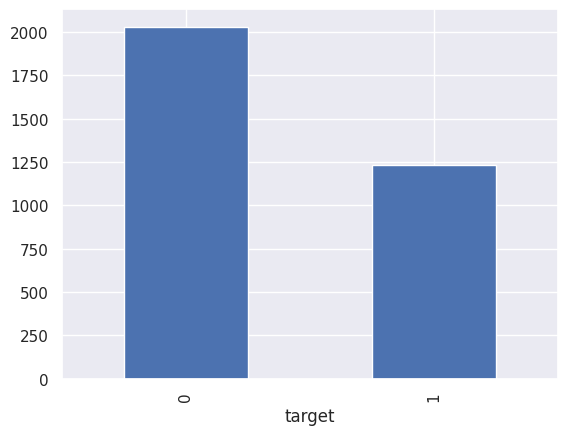

In [157]:
best_model = model_0
pred_val = model_0.predict(test_padded_sentences)
print("number of predictions:", len(pred_val))
# Shape the data for submission
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
ids = test_ids
submission_df = pd.DataFrame({'id': ids, 'target': label_pred_val})
if gDEBUG:
  submission_df.head()
submission_df.target.value_counts().plot.bar();

In [158]:
# Save the submission df to submit
submission_df.to_csv('submission_rnn_best_model_final.csv', index=False)

## Submission Results

Results were submitted to Kaggle competition for the best model and the submission received a public score of XXXXX.

| Model             | Val. Accuracy | Public Score   |
|:-----------------:|:-------------:|:--------------:|
| Model 3           | 0.914411      | 0.8591         |

# 12.&nbsp; References

**Kaggle Competition**

- [1] Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.


**Documentation and References**

- [2] Kaggle. KerasNLP starter notebook Disaster Tweets. 2023. https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
- [3] Kaggle. NLP Getting Started Tutorial. 2019. https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial
- [4] Kaggle. NLP with RNN for Tweet Analysis (79.9% acc). 2025. https://www.kaggle.com/code/jonchernoch/nlp-with-rnn-for-tweet-analysis-79-9-acc
- [5] Kaggle. Keras LSTM for Sentiment Disaster Analysis. 2020. https://www.kaggle.com/code/guidosalimbeni/keras-lstm-for-sentiment-disaster-analysis
- [6] Kaggle. NLP (Disaster Tweets) with Glove and LSTM. 2020. https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook
- [7] Kaggle. NLP 📝 GloVe, BERT, TF-IDF, LSTM... 📝 Explained. 2021. https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
